In [3]:
from pathlib import Path

import numpy as np
import cv2

from google.colab.patches import cv2_imshow

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo

from settings.paths import FILES_DIR, MODEL_DIR

/Users/markantipin/Desktop/Systemka/Segmentator/venv/lib/python3.6/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [4]:
cfg = get_cfg()

cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TEST = ()
# cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.MAX_ITER = 30000
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13



cfg.MODEL.WEIGHTS = Path(MODEL_DIR, "model_final.pth").as_posix()
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("fashion_val", )
predictor = DefaultPredictor(cfg)

In [5]:
test_image_path = Path(FILES_DIR, 'look1.jpg').as_posix()

In [6]:
fashion_metadata = MetadataCatalog.get('fashion').set(
            thing_classes=[
                'short sleeve top',
                'long sleeve top',
                'short sleeve outwear',
                'long sleeve outwear',
                'vest',
                'sling',
                'shorts',
                'trousers',
                'skirt',
                'short sleeve dress',
                'long sleeve dress',
                'vest dress',
                'sling dress'
            ])

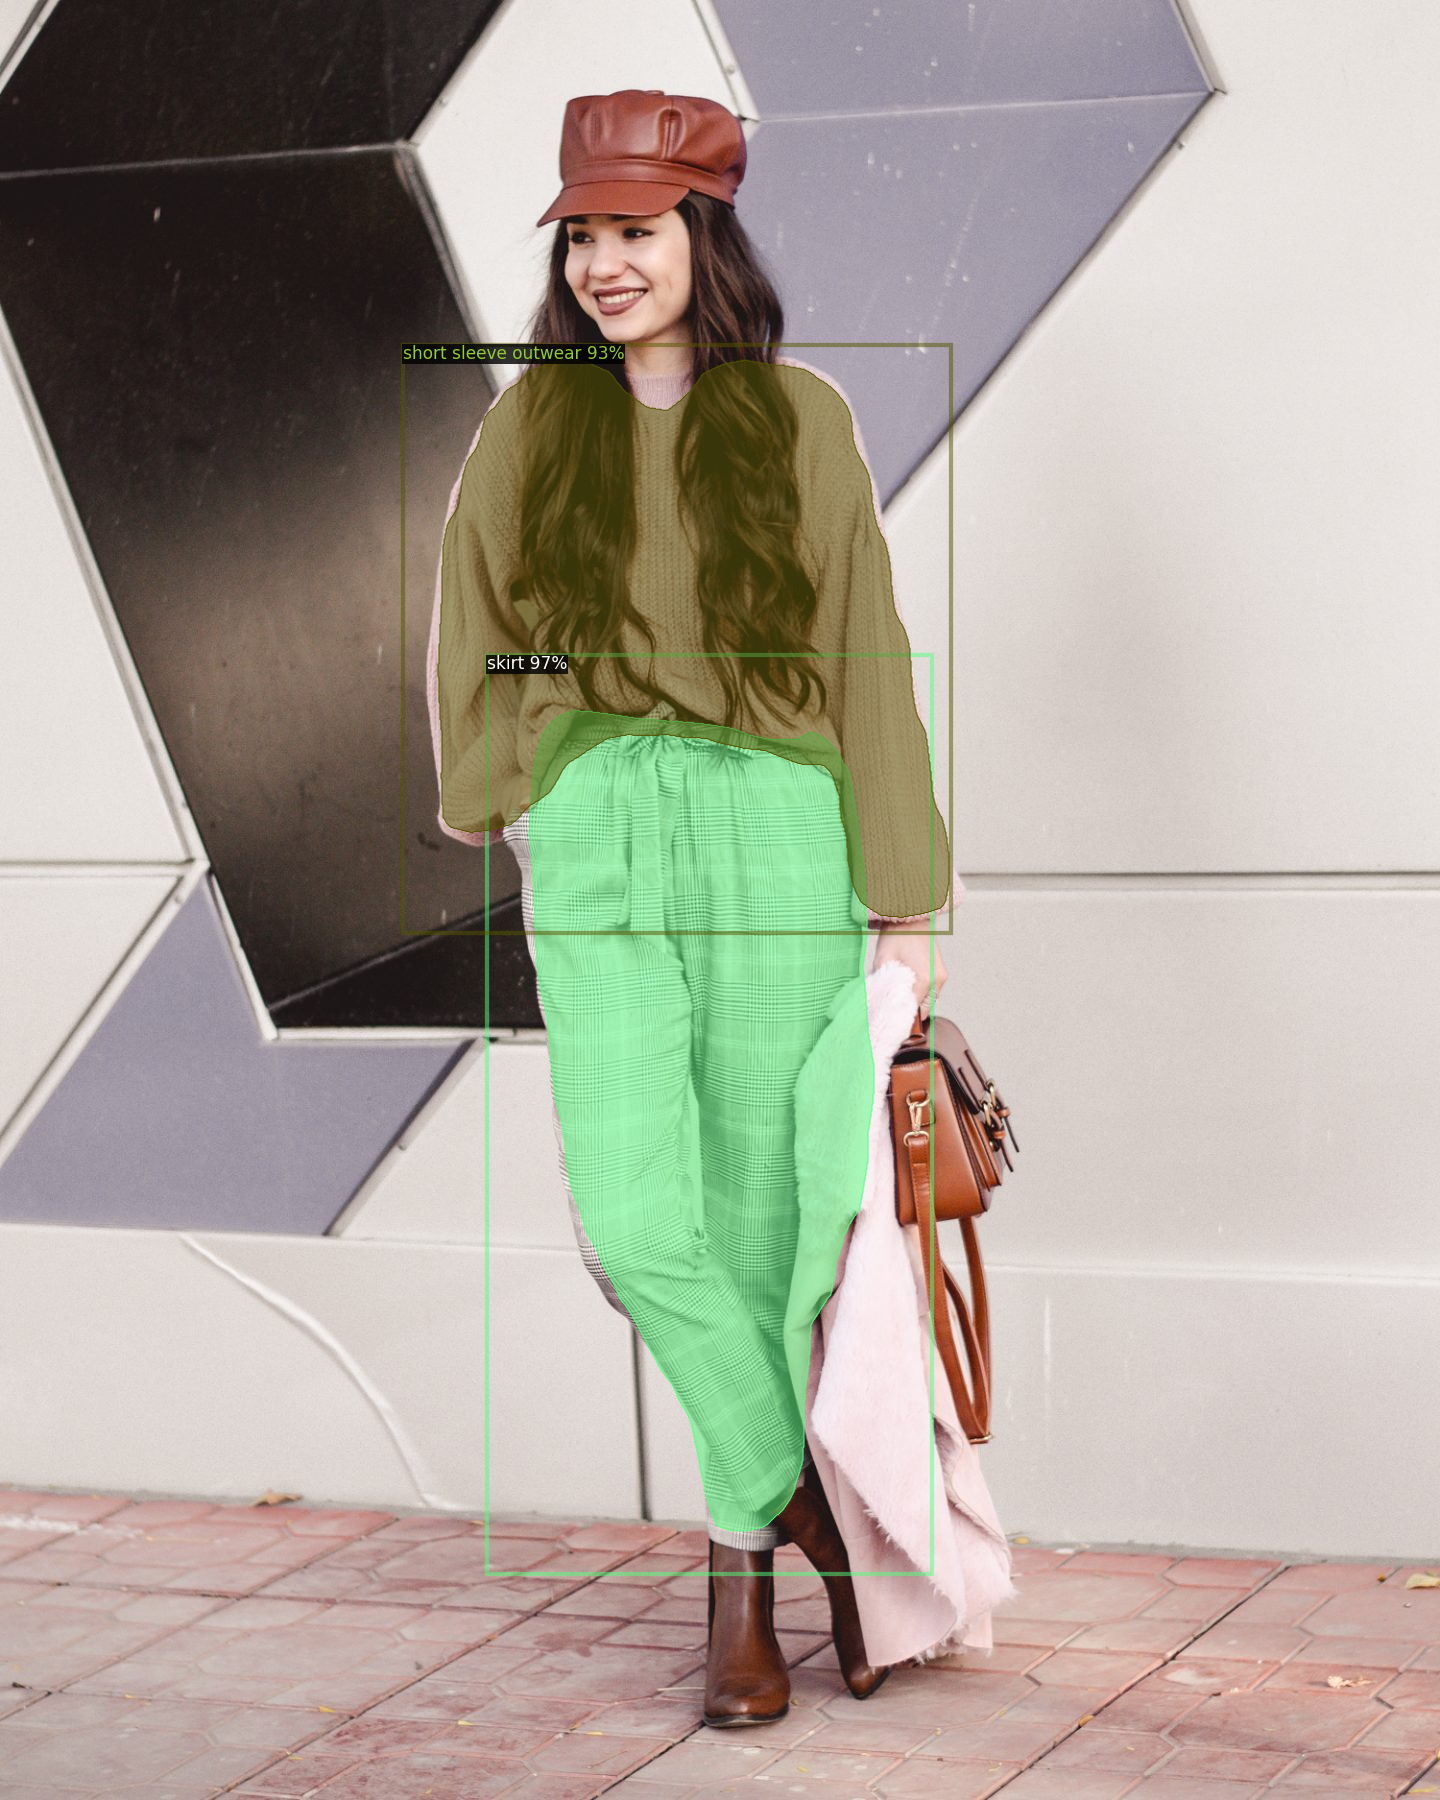

In [7]:
im = cv2.imread(test_image_path)

outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], metadata=fashion_metadata)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [8]:
im = cv2.imread(test_image_path)

for box in outputs["instances"].pred_boxes:
    x1, y1, x2, y2 = [round(cord) for cord in box.tolist()]
    crop_img = im[y1:y2, x1:x2]
#     cv2.imwrite('01.png',crop_img)

NameError: name 'cv' is not defined

In [9]:
outputs["instances"].pred_boxes

Boxes(tensor([[ 486.7533,  656.0644,  931.9635, 1574.0360],
        [ 402.8428,  345.9669,  951.2421,  933.9260]]))

In [26]:
round(1.3)

1